# Imports

In [2]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [3]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 372 µs (started: 2023-02-21 16:14:55 +00:00)


In [4]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
#import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 2.88 s (started: 2023-02-21 16:14:55 +00:00)


In [5]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'VGG16'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/inverted_otsu/
versión Keras: 2.11.0
time: 1.07 ms (started: 2023-02-21 16:14:58 +00:00)


In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.7 s (started: 2023-02-21 16:14:58 +00:00)


In [7]:
#quit()

time: 249 µs (started: 2023-02-21 16:15:00 +00:00)


# Funciones

In [8]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    #Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG16(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for vgg16
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated


def create_custom_model(NUM_CLASSES, FC_LAYER):

    # KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time:")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model: Modelo de Deep Learning
        - TYPE_IMG: regular o inverted
        - USE_DATA_AUG= sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name like VGG16 or DenseNet121
        - FC_LAYER: Number of Dense Layer. In this case is 4096
    '''

    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG + f'_FC_{FC_LAYER}__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.76 ms (started: 2023-02-21 16:15:00 +00:00)


# Imgs 64x64

- Test Accuracy: 0.7829847931861877
- Test Loss: 1.2425743341445923
- time: 35min 26s
- F1 score: 0.7849146167929589
- Precision score: 0.8057000511008725
- Recall:  0.7829848229342327
- Epoch: 22/50


## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/inverted_otsu/
time: 1.12 ms (started: 2023-02-21 13:49:33 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 6.35 s (started: 2023-02-21 13:49:34 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)

time: 1.12 ms (started: 2023-02-21 13:49:40 +00:00)


## Preparar el modelo

In [11]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 2.28 s (started: 2023-02-21 13:49:40 +00:00)


In [12]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 43.7 ms (started: 2023-02-21 13:49:42 +00:00)


In [13]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [14]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 101s 7ms/step - loss: 4.0851 - sparse_categorical_accuracy: 0.2263 - val_loss: 2.5395 - val_sparse_categorical_accuracy: 0.4266
Epoch 2/50
13899/13899 [==============================] - 96s 7ms/step - loss: 2.0198 - sparse_categorical_accuracy: 0.5271 - val_loss: 1.7662 - val_sparse_categorical_accuracy: 0.5808
Epoch 3/50
13899/13899 [==============================] - 97s 7ms/step - loss: 1.4740 - sparse_categorical_accuracy: 0.6420 - val_loss: 1.4101 - val_sparse_categorical_accuracy: 0.6604
Epoch 4/50
13899/13899 [==============================] - 96s 7ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.7038 - val_loss: 1.2226 - val_sparse_categorical_accuracy: 0.7023
Epoch 5/50
13899/13899 [==============================] - 96s 7ms/step - loss: 1.0246 - sparse_categorical_accuracy: 0.7439 - val_loss: 1.1482 - val_sparse_categorical_accuracy: 0.7214
Epoch 6/50
13899/13899 [==============================] - 97s 7ms/step - l

In [15]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.35 s (started: 2023-02-21 14:25:09 +00:00)


In [16]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 7s 3ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7829847931861877
- Test Loss: 1.2425743341445923
- time:
- F1 score: 0.7849146167929589
- Precision score: 0.8057000511008725
- Recall:  0.7829848229342327
- Epoch: 
*********************************************************************************************************************************
time: 19.1 s (started: 2023-02-21 14:25:10 +00:00)


## Graficando

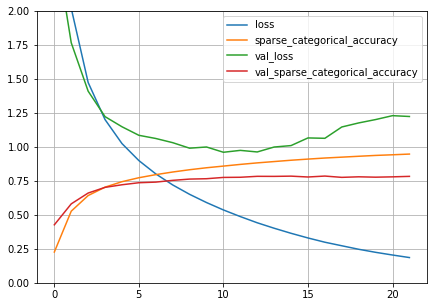

time: 267 ms (started: 2023-02-21 14:25:29 +00:00)


In [17]:
plot_loss(history)

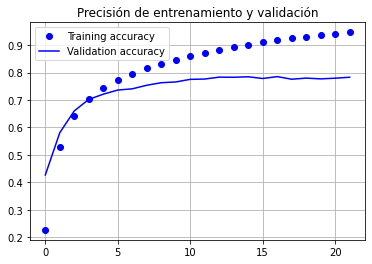

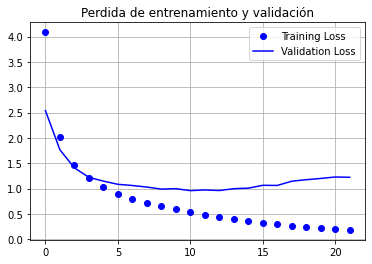

time: 396 ms (started: 2023-02-21 14:25:30 +00:00)


In [18]:
show_history(history)

In [19]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/inverted/model_vgg16_etl9_imgs64_inverted_FC_4096__OTSU.h5-------
time: 1.77 s (started: 2023-02-21 14:25:30 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8601517677307129
- Test Loss: 0.9038206338882446
- time: 42min 36s
- F1 score: 0.8612991574515454
- Precision score: 0.8756257838342533
- Recall:  0.8601517706576729
- Epoch: 21/50

## Cargar las imágenes

In [21]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/inverted_otsu/
time: 1.23 ms (started: 2023-02-21 14:27:30 +00:00)


In [22]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 15.1 s (started: 2023-02-21 14:27:31 +00:00)


In [23]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.14 ms (started: 2023-02-21 14:27:46 +00:00)


## Preparar el modelo

In [24]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 570 ms (started: 2023-02-21 14:27:46 +00:00)


In [25]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 37.3 ms (started: 2023-02-21 14:27:46 +00:00)


In [26]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

## Entrenar modelo

In [27]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 123s 9ms/step - loss: 3.1158 - sparse_categorical_accuracy: 0.3744 - val_loss: 1.5430 - val_sparse_categorical_accuracy: 0.6173
Epoch 2/50
13899/13899 [==============================] - 123s 9ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.6992 - val_loss: 1.0078 - val_sparse_categorical_accuracy: 0.7452
Epoch 3/50
13899/13899 [==============================] - 123s 9ms/step - loss: 0.8386 - sparse_categorical_accuracy: 0.7836 - val_loss: 0.9003 - val_sparse_categorical_accuracy: 0.7715
Epoch 4/50
13899/13899 [==============================] - 121s 9ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.8264 - val_loss: 0.7635 - val_sparse_categorical_accuracy: 0.8069
Epoch 5/50
13899/13899 [==============================] - 122s 9ms/step - loss: 0.5485 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.8275
Epoch 6/50
13899/13899 [==============================] - 121s 9ms/ste

In [28]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.01 s (started: 2023-02-21 15:10:23 +00:00)


In [29]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 8s 4ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8601517677307129
- Test Loss: 0.9038206338882446
- time:
- F1 score: 0.8612991574515454
- Precision score: 0.8756257838342533
- Recall:  0.8601517706576729
- Epoch: 
*********************************************************************************************************************************
time: 22.7 s (started: 2023-02-21 15:10:25 +00:00)


## Graficando

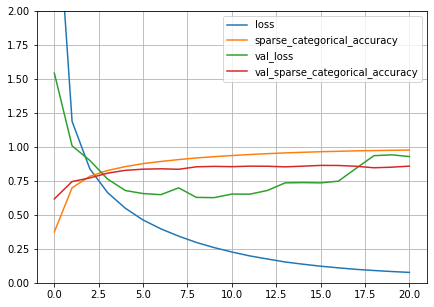

time: 214 ms (started: 2023-02-21 15:10:48 +00:00)


In [30]:
plot_loss(history)

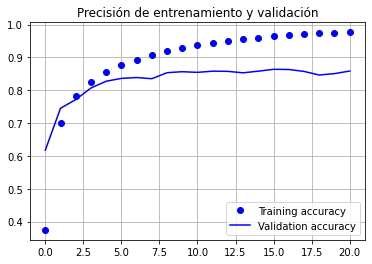

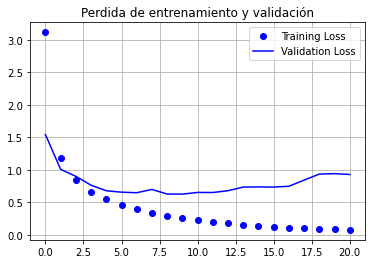

time: 630 ms (started: 2023-02-21 15:10:48 +00:00)


In [31]:
show_history(history)

In [32]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/inverted/model_vgg16_etl9_imgs96_inverted_FC_4096__OTSU.h5-------
time: 1.4 s (started: 2023-02-21 15:10:48 +00:00)


# Imgs 112x112 

- Test Accuracy: 0.8685328960418701
- Test Loss: 1.1415934562683105
- time: 1h 1min 17s
- F1 score: 0.8694679819215849
- Precision score: 0.8832197886752076
- Recall:  0.8685328836424958
- Epoch: 28/50

## Cargar imágenes

In [33]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 518 µs (started: 2023-02-21 15:10:50 +00:00)


In [34]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 19.8 s (started: 2023-02-21 15:10:50 +00:00)


In [35]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.21 ms (started: 2023-02-21 15:11:10 +00:00)


## Preparar el modelo

In [36]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 575 ms (started: 2023-02-21 15:11:10 +00:00)


In [37]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 34.4 ms (started: 2023-02-21 15:11:10 +00:00)


In [38]:
print(custom_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

## Entrenar modelo


In [39]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 133s 9ms/step - loss: 2.6050 - sparse_categorical_accuracy: 0.4656 - val_loss: 1.2153 - val_sparse_categorical_accuracy: 0.6918
Epoch 2/50
13899/13899 [==============================] - 131s 9ms/step - loss: 0.9219 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.8523 - val_sparse_categorical_accuracy: 0.7801
Epoch 3/50
13899/13899 [==============================] - 131s 9ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.8307 - val_loss: 0.6990 - val_sparse_categorical_accuracy: 0.8213
Epoch 4/50
13899/13899 [==============================] - 131s 9ms/step - loss: 0.5031 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.6192 - val_sparse_categorical_accuracy: 0.8419
Epoch 5/50
13899/13899 [==============================] - 131s 9ms/step - loss: 0.4080 - sparse_categorical_accuracy: 0.8909 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.8467
Epoch 6/50
13899/13899 [==============================] - 131s 9ms/ste

## Métricas

In [43]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.57 s (started: 2023-02-21 16:12:30 +00:00)


In [44]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 9s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8685328960418701
- Test Loss: 1.1415934562683105
- time:
- F1 score: 0.8694679819215849
- Precision score: 0.8832197886752076
- Recall:  0.8685328836424958
- Epoch: 
*********************************************************************************************************************************
time: 24.4 s (started: 2023-02-21 16:12:33 +00:00)


## Graficando

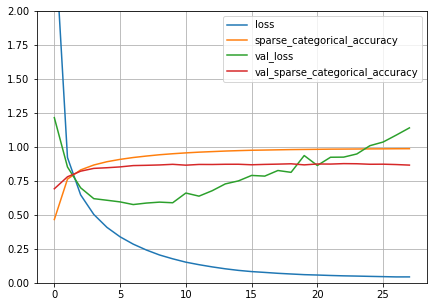

time: 194 ms (started: 2023-02-21 16:12:28 +00:00)


In [40]:
plot_loss(history)

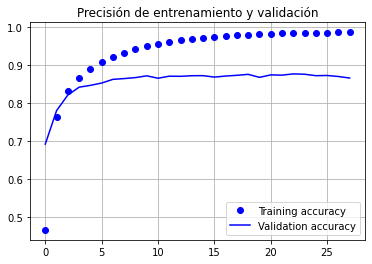

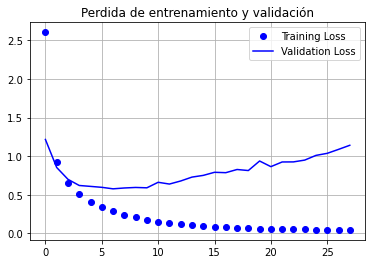

time: 379 ms (started: 2023-02-21 16:12:29 +00:00)


In [41]:
show_history(history)

In [42]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/inverted/model_vgg16_etl9_imgs112_inverted_FC_4096__OTSU.h5-------
time: 1.4 s (started: 2023-02-21 16:12:29 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8789882063865662
- Test Loss: 1.0747264623641968
- time: 1h 10min 50s
- F1 score: 0.8799362673542427
- Precision score: 0.8921060186176445
- Recall:  0.8789881956155143
- Epoch: 27/50



## Cargar imágenes

In [10]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/inverted_otsu/
time: 659 µs (started: 2023-02-21 16:15:24 +00:00)


In [11]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24.3 s (started: 2023-02-21 16:15:24 +00:00)


In [12]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.51 ms (started: 2023-02-21 16:15:49 +00:00)


## Preparar el modelo

In [13]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 2.35 s (started: 2023-02-21 16:15:49 +00:00)


In [14]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 50 ms (started: 2023-02-21 16:15:51 +00:00)


In [15]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

## Entrenar modelo

In [16]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 165s 12ms/step - loss: 2.3374 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.0426 - val_sparse_categorical_accuracy: 0.7328
Epoch 2/50
13899/13899 [==============================] - 159s 11ms/step - loss: 0.7942 - sparse_categorical_accuracy: 0.7923 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.8076
Epoch 3/50
13899/13899 [==============================] - 159s 11ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.6008 - val_sparse_categorical_accuracy: 0.8435
Epoch 4/50
13899/13899 [==============================] - 159s 11ms/step - loss: 0.4245 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.5700 - val_sparse_categorical_accuracy: 0.8557
Epoch 5/50
13899/13899 [==============================] - 160s 11ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.5444 - val_sparse_categorical_accuracy: 0.8621
Epoch 6/50
13899/13899 [==============================] - 159s 11

## Graficando

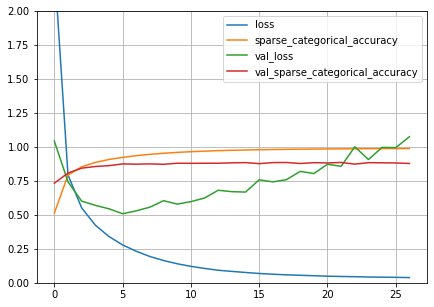

time: 250 ms (started: 2023-02-21 17:26:42 +00:00)


In [17]:
plot_loss(history)

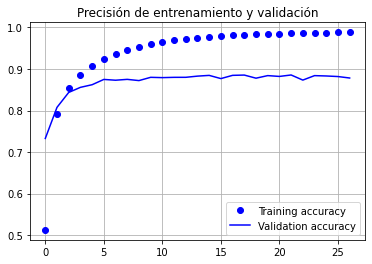

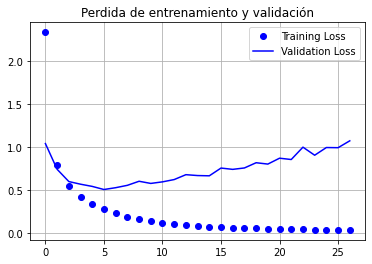

time: 362 ms (started: 2023-02-21 17:26:42 +00:00)


In [18]:
show_history(history)

In [19]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/inverted/model_vgg16_etl9_imgs127_inverted_FC_4096__OTSU.h5-------
time: 1.43 s (started: 2023-02-21 17:26:42 +00:00)


## Métricas

In [20]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.15 s (started: 2023-02-21 17:26:44 +00:00)


In [21]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 12s 7ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8789882063865662
- Test Loss: 1.0747264623641968
- time:
- F1 score: 0.8799362673542427
- Precision score: 0.8921060186176445
- Recall:  0.8789881956155143
- Epoch: 
*********************************************************************************************************************************
time: 32.7 s (started: 2023-02-21 17:26:47 +00:00)


In [ ]:
runtime.unassign()